Install pytorch

In [200]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets as tv_datasets
print(torch.__version__)

2.0.1+cu118


In [201]:
# transformations for data
from torchvision import transforms
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # You can see the difference with normalization and without it
        ])
# import data
train_dataset = tv_datasets.MNIST(root='./mnist_train', train=True, download=True, transform=transform)
test_dataset = tv_datasets.MNIST(root="./mnist_test", train=False, download=True, transform=transform)

In [202]:
print("Train dataset: \n", train_dataset)
print("\nTest dataset details: \n", test_dataset)

Train dataset: 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Test dataset details: 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist_test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [203]:
# create its batches as well
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 256)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)

<class 'tuple'>
type of image:  <class 'torch.Tensor'>


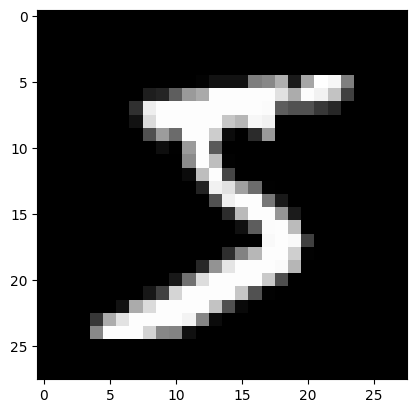

Class of image: 5


In [207]:
# visualise an image of mnist
# check the type of datloader items first to find out how wo visualise it
print(type(train_dataset[0]))

input_image, target_class = train_dataset[0]
print("type of image: ", type(input_image))

import matplotlib.pyplot as plt
plt.imshow(input_image.squeeze(), cmap="gray")
plt.show()
print("Class of image:", target_class)

In [208]:
# build model
class MnistClassifier(nn.Module):
    def __init__(self, in_features=784, n_classes=10, act_func="gelu"):
        super().__init__()
        self.linear1 = nn.Linear(in_features, in_features)
        if act_func == "gelu":
            self.act = nn.GELU()
        else:
            self.act = nn.ReLU()
        self.linear2 = nn.Linear(in_features, n_classes)

    def forward(self, x):
        lin_output_1 = self.linear1(x)
        act_output = self.act(lin_output_1)
        final_output = self.linear2(act_output)
        # returning log likelihood along last dimension
        output = F.log_softmax(final_output, dim=-1)
        return output

mnist_classifier = MnistClassifier()

In [209]:
# count number of trainable parameters in model
total_n_parameters = sum(p.numel() for p in mnist_classifier.parameters() if p.requires_grad)

print(f"Number of parameters in the model is : {total_n_parameters}")

Number of parameters in the model is : 623290


In [232]:
from sklearn.metrics import accuracy_score

# define training/testing function:
def run(model, data_loader, optimizer, mode="train", device="cpu",
        log_interval=4):
    if mode == "train":
        model.train()
    else:
        model.eval()

    prev_loss = 10.0
    pred_class = None
    prev_accuracy_score = 110.0
    loss_list = []
    current_loss = 0.0

    while(True):
        pred_class_list = []
        target_class_list = []
        for batch_idx, (data, target) in enumerate(data_loader):
            data = torch.reshape(data, (-1,784))
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # Making all the grads to be zero
            output = model(data)
            loss = F.nll_loss(output, target)
            pred_class = output.argmax(dim=-1)  #compute the predicted classes


            target_class_list += list(target.detach().numpy())
            pred_class_list += list(pred_class.detach().numpy())

            current_loss = float(loss)

            loss_list.append(current_loss)
            if mode == "train":
                loss.backward()
                optimizer.step()


            prev_loss = float(loss)
            if (batch_idx+1) % log_interval == 0:
                # you can use logging to file as well
                print(f"Batch_no: {batch_idx + 1} loss: {float(loss):.4f}")

        # calculate accuracy for this epoch
        acc_score = accuracy_score(target_class_list, pred_class_list)
        print(f"Accuracy score for entire dataset: {acc_score:.3f}")

        # Loop breaking criteria
        # if change in loss is smaller than certain values
        # if (prev_loss - current_loss < 0.01 and prev_loss > current_loss) or not(mode == "train"):
        #     break

        # Using change in accuracy score as loop break criteria
        if prev_accuracy_score - acc_score < 0.008 or not(mode == "train"):
            break

        prev_accuracy_score = acc_score

    model.train()
    # print(f"Avg loss: {sum(loss_list)/len(loss_list)}")
    return loss_list, float(loss), pred_class


In [227]:
model = mnist_classifier
# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

Batch_no: 64 loss: 0.0084
Batch_no: 128 loss: 0.0240
Batch_no: 192 loss: 0.0372
Accuracy score for entire dataset: 0.996
Batch_no: 64 loss: 0.0067
Batch_no: 128 loss: 0.0169
Batch_no: 192 loss: 0.0257
Accuracy score for entire dataset: 0.998


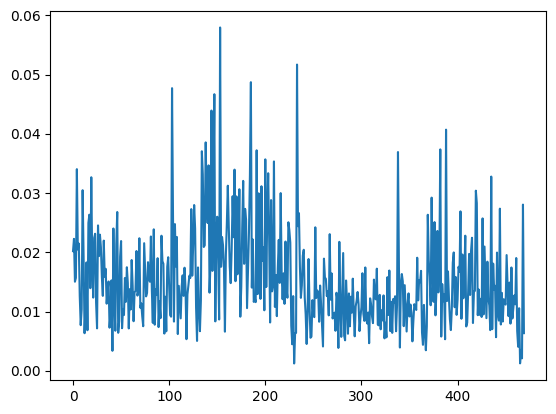

In [228]:
# Run training
loss_list, _, pred_class = run(model, data_loader=train_loader, optimizer=optimizer, mode="train", device="cpu",
    log_interval=64)
plt.plot(loss_list)
plt.show()

In [234]:
# Run testing
_, _, _ = run(model, data_loader= test_loader, optimizer=optimizer, mode="test", device="cpu",
              log_interval=1000)

Accuracy score for entire dataset: 0.978
